In [ ]:
import os
import math
import torch
import torchvision
import cv2
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchsummary import summary
from PIL import Image
from tqdm import tqdm

##Setting the device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
architecture = [[
#tuple : (kernel_size, n_filters, stride)
(5,24,2),
(5,36,2),
(5,48,2),
(3,64,1),
(3,64,1)],
[
# int : n_neurons
1152,
 100,
  50,
  10,
   1
]]

In [ ]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
class ATan(nn.Module):
  def __init__(self):
    super(Atan, self).__init__()

  def forward(self, x):
    return torch.atan(x)

class DriveNet(nn.Module):
  def __init__(self, architecture):
    super(DriveNet, self).__init__()
    self.net = self._create_layers(architecture)

  def forward(self, x):
    return self.net(x)

  def _create_layers(self, architecture, in_channels=3):
    layers = []
    #architecture should have two parts. First part should contain conv layers and second part should contain linear layers.
    for x in architecture[0]:
      if type(x) == tuple:
        layers.append(nn.Conv2d(in_channels, out_channels=x[1], kernel_size=x[0], stride=x[2], padding=0))
        nn.init.trunc_normal_(layers[-1].weight,std=0.1)
        layers.append(nn.ReLU())
        in_channels = x[1]
    
    layers.append(nn.Flatten())
    in_features = architecture[1][0]
    for x in architecture[1][1:]:
      layers.append(nn.Linear(in_features, x))
      nn.init.trunc_normal_(layers[-1].weight,std=0.1)
      layers.append(nn.ReLU())
      in_features = x
    layers = layers[:-1]
    layers.append(Atan())

    return nn.Sequential(*layers)

##Custom Dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, txt, set_type):
    self.data_dir = data_dir
    self.data = []
    with open(os.path.join(self.data_dir, txt)) as file:
      text = file.read().strip()
      for line in text.split('\n'):
        x, y = line.split()
        self.data.append([x, float(y)])
    if set_type=='train':
      self.data = self.data[:int(0.8*len(self.data))]
    elif set_type=='test':
      self.data = self.data[int(0.8*len(self.data)):]
      
  def __len__(self):
    return len(self.data)
      
  def __getitem__(self, idx):
    img_pth = os.path.join(self.data_dir, self.data[idx][0])
    image = torchvision.io.read_image(img_pth)
    image = image[:,150:,:]
    image = torchvision.transforms.Resize((66,200))(image)
    image = image/255.0
    angle = torch.tensor([self.data[idx][1]*math.pi/180], dtype=torch.float32)

    return self.data[idx][0], image, angle

In [ ]:
def save_chkpt(model, optim, filename='drive/MyDrive/DriveCNN.pth.tar'):
  chkpt = {'model':model.state_dict(),'optim':optim.state_dict()}
  torch.save(chkpt, filename)

def load_chkpt(model, optim=None, filename='drive/MyDrive/DriveCNN.pth.tar'):
  chkpt = torch.load(filename)
  model.load_state_dict(chkpt['model'])
  if optim!=None:
    optim.load_state_dict(chkpt['optim'])

In [ ]:
epoch_losses = []
def train(data_dir, txt, model, optim, loss_fn, epochs):
  train_set = Dataset(data_dir,txt,'train')
  train_loader = torch.utils.data.DataLoader(train_set, 64, num_workers=16)
  for epoch in range(epochs):
    batch_losses = []
    if epoch%1==0 and epoch!=0:
      save_chkpt(model, optim)
    loop = tqdm(train_loader,  position=0, leave=True)
    for filename, x, y in loop:
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      batch_losses.append(loss.item())
      optim.zero_grad()
      loss.backward()
      optim.step()
      loop.set_postfix(loss=loss)

    epoch_losses.append(sum(batch_losses)/len(batch_losses))
  return

In [ ]:
load_model = False
model = DriveNet(architecture).to(device)
loss = nn.MSELoss().to(device)
optim = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=0.001)

if load_model:
  load_chkpt(model)

In [ ]:
summary(model,(3,66,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 31, 98]           1,824
              ReLU-2           [-1, 24, 31, 98]               0
            Conv2d-3           [-1, 36, 14, 47]          21,636
              ReLU-4           [-1, 36, 14, 47]               0
            Conv2d-5            [-1, 48, 5, 22]          43,248
              ReLU-6            [-1, 48, 5, 22]               0
            Conv2d-7            [-1, 64, 3, 20]          27,712
              ReLU-8            [-1, 64, 3, 20]               0
            Conv2d-9            [-1, 64, 1, 18]          36,928
             ReLU-10            [-1, 64, 1, 18]               0
          Flatten-11                 [-1, 1152]               0
           Linear-12                  [-1, 100]         115,300
             ReLU-13                  [-1, 100]               0
           Linear-14                   

In [ ]:
train('drive/MyDrive/driving_dataset','data.txt',model,optim,loss,10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 568/568 [01:22<00:00,  6.86it/s, loss=tensor(0.3415, device='cuda:0', grad_fn=<MseLossBackward>)]


In [ ]:
 def test(data_dir, txt, model):
  y_test = []
  test_set = Dataset(data_dir,txt,'test')
  test_loader = torch.utils.data.DataLoader(test_set, 64, num_workers=16)
  loop = tqdm(test_loader,  position=0, leave=True)
  for filename, x, y in loop:
    x = x.to(device)
    y_hat = model(x)
    y_test.extend(zip(filename, y*180.0/math.pi, y_hat*180.0/math.pi))
  return y_test

In [ ]:
y_test = test('drive/MyDrive/driving_dataset','data.txt',model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 56%|█████▋    | 80/142 [00:12<00:07,  8.55it/s]

RuntimeError: ignored

In [ ]:
y_test.sort(key=lambda x:x[0])

In [ ]:
y_test[1]

('36325.jpg',
 tensor([-10.7900]),
 tensor([40.1104], device='cuda:0', grad_fn=<UnbindBackward>))

In [ ]:
images = [x[0] for x in y_test]
true = np.array([float(x[1]) for x in y_test])
pred = np.array([float(x[2]) for x in y_test])
print(sum((true-pred)**2)/len(pred))
print(sum((true-0)**2)/len(pred))

1079.7923210103959
626.6582944704907


In [ ]:
import csv
y = []
for filename, true, pred in y_test:
  y.append([filename, float(true),float(pred)])
with open('drive/MyDrive/y_test_new.csv','w') as file:
  csv_writer = csv.writer(file)
  csv_writer.writerows(y)

In [ ]:
 'y_test.csv' in os.listdir('drive/MyDrive/driving_dataset')

True

In [ ]:
wheel = cv2.imread('drive/MyDrive/driving_dataset/steering_wheel_image.jpg')
cols, rows = wheel.shape[0], wheel.shape[1]
i = int(y_test[0][0].replace('.jpg',''))
idx = 0
smoothed_angle = 0

In [ ]:
while cv2.waitKey(10)!=ord('q'):
  image = cv2.imread(f'drive/MyDrive/driving_dataset/{str(i)}.jpg')
  angle = y_test[idx][2]
  smoothed_angle += 0.2*pow(abs((angle-smoothed_angle)), 2.0/3.0)*(angle-smoothed_angle)/abs(angle-smoothed_angle)
  cv2_imshow(image)
  M = cv2.getRotationMatrix2D((cols/2, rows/2),-smoothed_angle, 1)
  dst = cv2.warpAffine(wheel,M,(cols,rows))
  cv2_imshow(dst)
  i += 1
  idx += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
  from google.colab.patches import cv2_imshow

In [ ]:
image = torchvision.io.read_image('drive/MyDrive/driving_dataset/1000.jpg').permute(1,2,0)

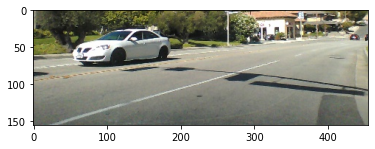

In [ ]:
plt.imshowi(mage[100:,:,:])

In [ ]:
import csv

In [ ]:
class Dataset:
  def __init__(self, data_dir, txt, set_type):
    self.data_dir = data_dir
    self.data = []
    with open(os.path.join(self.data_dir, txt)) as file:
      text = file.read().strip()
      for line in text.split('\n'):
        x, y = line.strip().split()
        self.data.append([x, float(y)])
    if set_type=='train':
      self.data = self.data[:int(0.8*len(self.data))]
    elif set_type=='test':
      self.data = self.data[int(0.8*len(self.data)):]
      
  def getdata(self):
    images = []
    angles = []
    for image_name, angle in self.data:
      image = torchvision.io.read_image(os.path.join(self.data_dir, image_name))
      image = image[:,100:,:]
      image = torchvision.transforms.Resize((66,200))(image)/255.0
      images.append(image)
      angles.append(angle*math.pi/180)
    images = torch.tensor(images)
    angles = torch.tensor(angles, dtype=torch.float32)

    return images, angles

In [ ]:
x_train, y_train = Dataset('drive/MyDrive/driv ing_dataset','data.txt','train').getdata()

KeyboardInterrupt: ignored

In [ ]:
 class DataLoader:
  def __init__(self, x_train, y_train, batch_size):
    self.x_train = x_train
    self.y_train = y_train
    self.batch_size = batch_size
    self.start = -batch_size
    self.completed = False


  def __iter__(self):
    return self

  def __next__(self):
    if self.completed==False:
      if len(self.x_train)-self.start>self.batch_size:
        self.start = self.start + self.batch_size
        self.end = self.start + self.batch_size
        return self.x_train[self.start:self.end], self.y_train[self.start:self.end]
      else:
        self.completed = True
        return self.x_train[self.start:], self.y_train[self.start:]
    else:
      raise StopIteration

In [ ]:
def load(lst, data):
  for filename in lst:
    image = torchvision.io.read_image(f'drive/MyDrive/driving_dataset/{filename}')[:,100:,:]
    image = torchvision.transforms.Resize((66,200))(image)
    lst.append((filename,image))

In [ ]:
x_train = []
y_train = []
for filename1, angle in data:
  for filename2, image in lst:
    if filename1==filename2:
      x_train.append(image)
      y_train.append(angle)
      break

In [ ]:
with open('drive/MyDrive/driving_dataset/data.txt') as file:
  text = file.read()